<a href="https://colab.research.google.com/github/merazAfridi/Blood-Cell-Segmentation/blob/main/5_Attention_Unet_Blood_cell_seg_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras


In [ ]:
import tensorflow as tf
import google.protobuf

print("TensorFlow version:", tf.__version__)
print("Protobuf version:", google.protobuf.__version__)


TensorFlow version: 1.15.0
Protobuf version: 3.19.0


In [ ]:
data_path = r'C:\Users\User\Final data'

In [ ]:
image_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
mask_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'

(1328, 128, 128, 3)
uint8


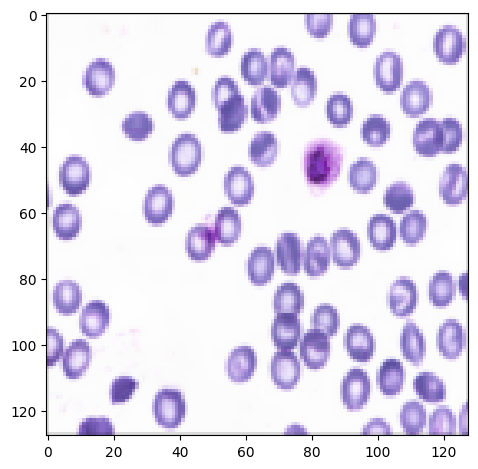

In [ ]:
#X train pure images from dataset
row = 128
columns = 128

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Original'
training_images = os.listdir(train_data_path)
training_images.sort()


X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_images:
    path = os.path.join(image_data_path, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    X[index] = image
    index += 1

print(X.shape)

print(X.dtype)
imshow(X[0])

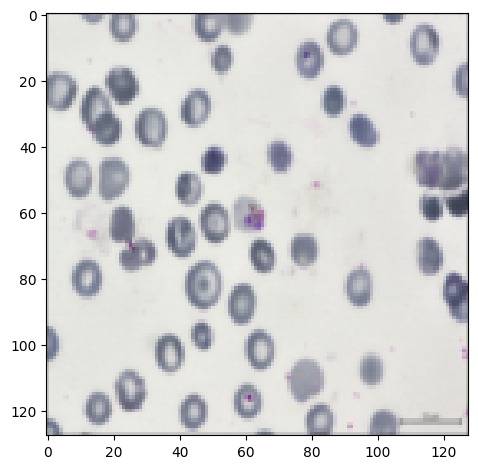

In [ ]:
imshow(X[10])

(1328, 128, 128, 3)
uint8


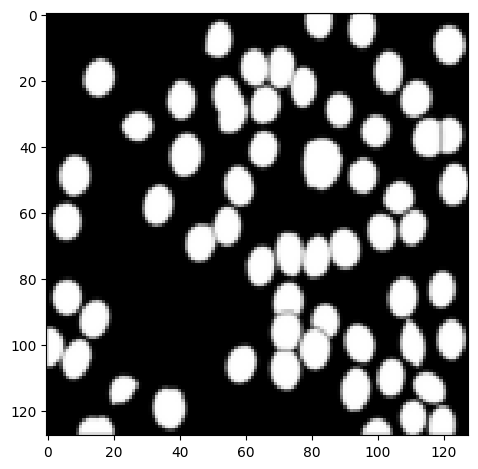

In [ ]:
## y train pure masks from dataset

train_data_path =r'C:\Users\User\Final data\Final data\New folder\Mask'
training_masks = os.listdir(train_data_path)
training_masks.sort()

y = np.zeros((len(training_masks), row, columns, 3), dtype=np.uint8)

index = 0
for x in training_masks:
    path = os.path.join(mask_data_path, x)
#     print(path)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    #image.resize((128,128,1))
    y[index] = image
    index += 1

print(y.shape)
type(y)
print(y.dtype)
imshow(y[0])

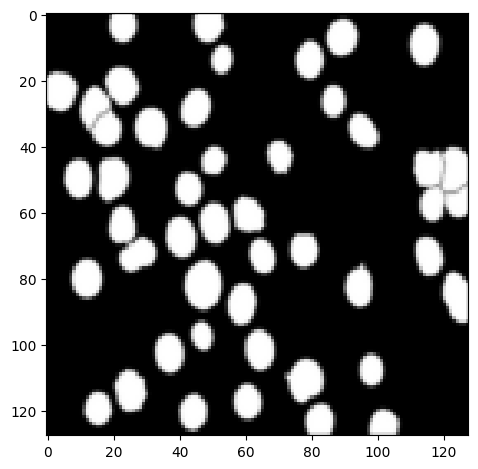

In [ ]:
imshow(y[10])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)


(1062, 128, 128, 3)
(1062, 128, 128, 3)

(266, 128, 128, 3)
(266, 128, 128, 3)


In [ ]:
y_train = y_train.astype('bool')
print(y_train.dtype)

bool


In [ ]:
def dice_coef(a, b):

    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
#Libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose
# from keras.backend as K
import tensorflow.keras.backend as K
import tensorflow as tf


In [ ]:
# Import necessary libraries from TensorFlow's Keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input, add, multiply
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [ ]:
#Attention U-net

def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    if data_format == 'channels_first':
        in_channel = down_layer.get_shape().as_list()[1]
    else:
        in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    if data_format == 'channels_first':
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))
    else:
        my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate

def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)
    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)
    f = Activation('relu')(add([theta_x, phi_g]))
    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = multiply([x, rate])
    return att_x

# Attention U-Net
def att_unet(img_w, img_h, n_label, data_format='channels_last'):
    inputs = Input((img_w, img_h, 3))  # channels_last format
    x = inputs

    depth = 4
    features = 64
    skips = []

    for i in range(depth):
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        skips.append(x)
        x = MaxPooling2D((2, 2), data_format=data_format)(x)
        features = features * 2

    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    for i in reversed(range(depth)):
        features = features // 2
        x = attention_up_and_concate(x, skips[i], data_format=data_format)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)
        x = Dropout(0.2)(x)
        x = Conv2D(features, (3, 3), activation='relu', padding='same', data_format=data_format)(x)

    conv6 = Conv2D(n_label, (1, 1), padding='same', data_format=data_format)(x)
    conv7 = Activation('sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=conv7)

    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, jaccard_index])

    return model


In [ ]:
model = att_unet(128,128, 3)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 128, 128, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 64) 0           conv2d_173[0][0]                 
__________________________________________________________________________________________________
conv2d_174 (Conv2D)             (None, 128, 128, 64) 36928       dropout_18[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Training

print(X_train.shape)
print(y_train.shape)

(1062, 128, 128, 3)
(1062, 128, 128, 3)


In [ ]:
filepath = r"C:\Users\User\Blood Cell Seg ipybn\Atttention U net/cp.ckpt"

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [checkpoint]
#earlystopper,
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=8, epochs=5, callbacks=callbacks_list)

Train on 955 samples, validate on 107 samples
Epoch 1/5
952/955 [============================>.] - ETA: 15s - loss: 0.3141 - dice_coef: 0.7620 - jaccard_index: 0.6286
Epoch 00001: val_loss improved from inf to 0.31318, saving model to C:\Users\User\Blood Cell Seg ipybn\Atttention U net/cp.ckpt
955/955 [==============================] - 5241s 5s/sample - loss: 0.3137 - dice_coef: 0.7629 - jaccard_index: 0.6298 - val_loss: 0.3132 - val_dice_coef: 0.7839 - val_jaccard_index: 0.6494
Epoch 2/5
952/955 [============================>.] - ETA: 19s - loss: 0.1953 - dice_coef: 0.8640 - jaccard_index: 0.7621 
Epoch 00002: val_loss improved from 0.31318 to 0.23884, saving model to C:\Users\User\Blood Cell Seg ipybn\Atttention U net/cp.ckpt
955/955 [==============================] - 6374s 7s/sample - loss: 0.1952 - dice_coef: 0.8643 - jaccard_index: 0.7627 - val_loss: 0.2388 - val_dice_coef: 0.8355 - val_jaccard_index: 0.7217
Epoch 3/5
952/955 [============================>.] - ETA: 19s - loss: 0.1

In [ ]:
print(X_test.shape)
print(y_test.shape)

(266, 128, 128, 3)
(266, 128, 128, 3)


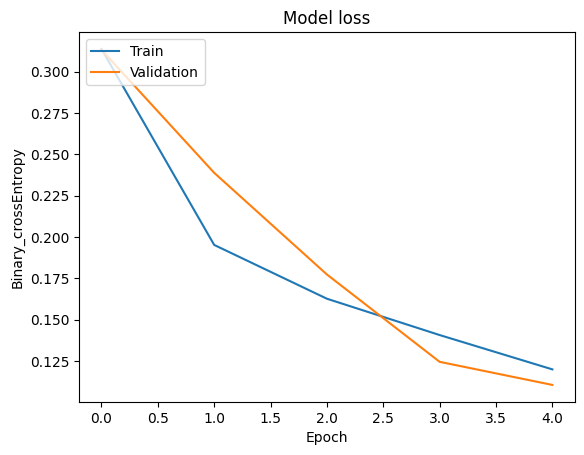

In [ ]:
#Plotting history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

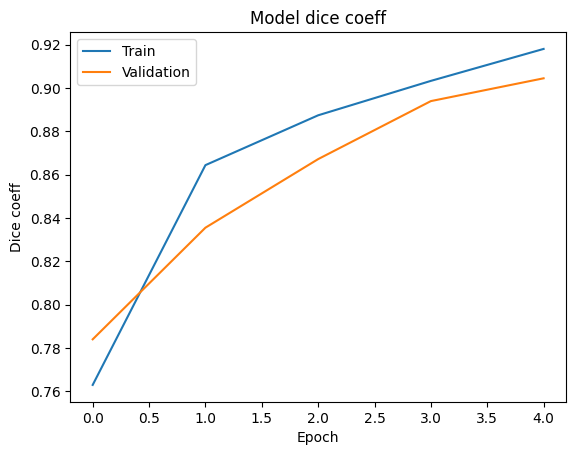

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

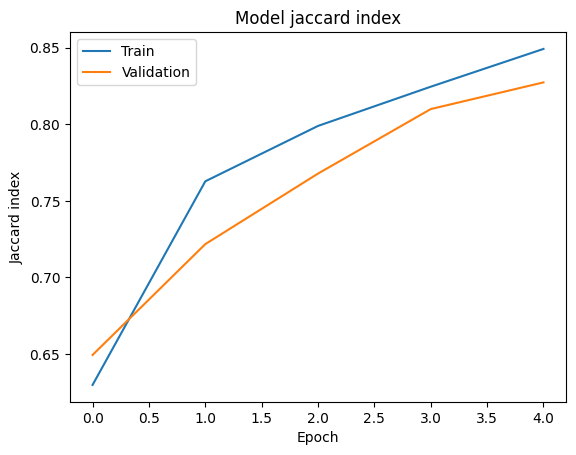

In [ ]:
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#Testing
#from keras.models import load_model
#model = load_model('./assets')
#model.load_weights(r"C:\Users\User\Blood Cell Seg ipybn\Atttention U net/cp.ckpt")

test_preds = model.predict(X_test)
print(test_preds.shape)
print(type(test_preds))

(266, 128, 128, 3)
<class 'numpy.ndarray'>


<class 'numpy.ndarray'>
(266, 128, 128, 3)
float32


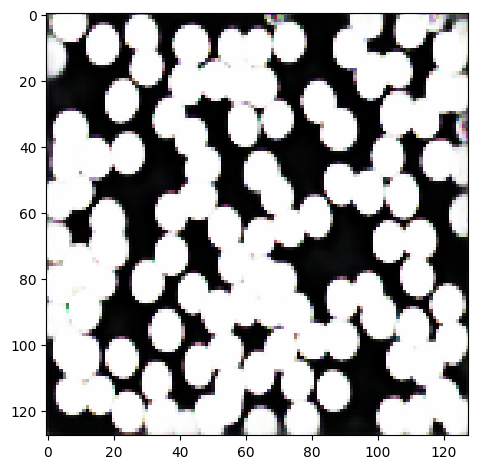

In [ ]:
print(type(test_preds))
print(test_preds.shape)
print(test_preds.dtype)
#print(test_preds[0])
imshow(test_preds[0].reshape(128, 128, 3))

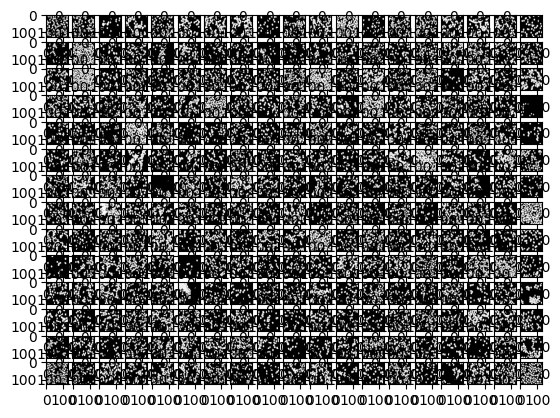

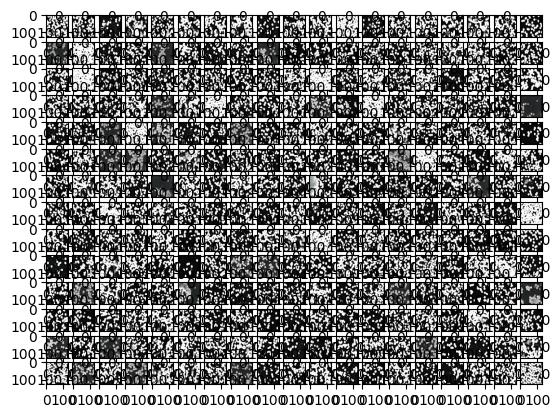

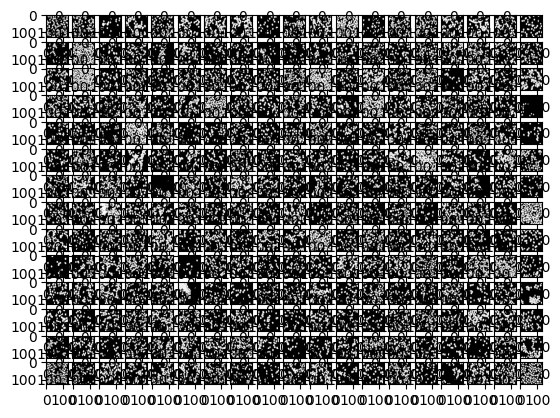

In [ ]:
from skimage.io import imshow_collection
imshow_collection(test_preds.reshape(266, 128, 128, 3))
imshow_collection(y_test)

In [ ]:
#Evaluating Individual Dice-Co efficient
#Metrics for individual evaluation

def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

uint8
<dtype: 'float32'>
Dice Co-efficient:  Tensor("truediv_3033:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_3035:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


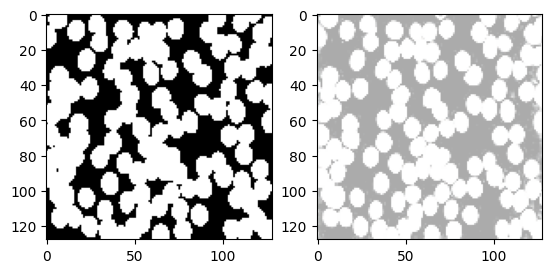

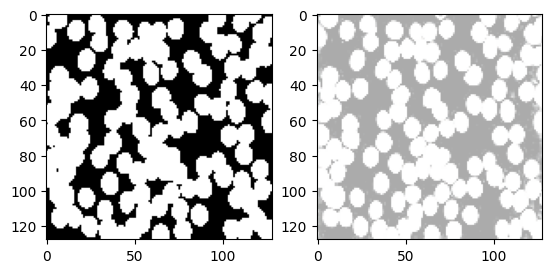

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test and avg_output
print(y_test[0].dtype)
print(avg_output[0].dtype)

# Convert both to the same dtype (e.g., float32)
i = tf.cast(y_test[0], dtype=tf.float32)
j = tf.cast(avg_output[0], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

# same shape for both images
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))  # Assuming 3 channels (RGB)
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


uint8
<dtype: 'float32'>
Dice Co-efficient:  Tensor("truediv_3037:0", shape=(), dtype=float32)
Jaccard-index:  Tensor("truediv_3039:0", shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


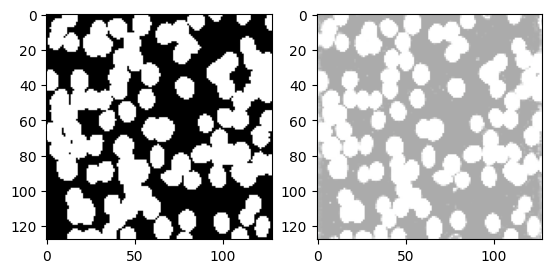

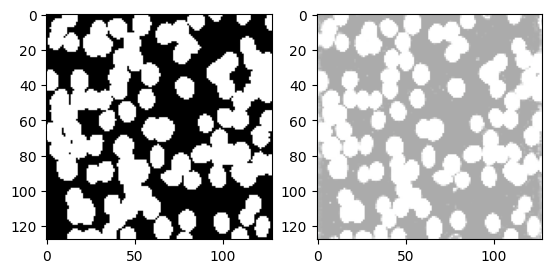

In [ ]:
import numpy as np
import tensorflow as tf
from skimage.io import imshow_collection

# correct data type for y_test and avg_output
print(y_test[1].dtype)  # Expected to be uint8
print(avg_output[1].dtype)  # Expected to be float32

# Convert both to the same dtype (e.g., float32)
i = tf.cast(y_test[1], dtype=tf.float32)
j = tf.cast(avg_output[1], dtype=tf.float32)

# Calculate Dice Coefficient
result = dice_coef2(i, j)
print('Dice Co-efficient: ', result)

# Calculate Jaccard Index
result2 = jaccard_index2(i, j)
print('Jaccard-index: ', result2)

# same shape for both images
if i.shape != j.shape:
    j = tf.image.resize(j, i.shape[:2])  # Resize j to match i

# Convert Tensor to NumPy array
with tf.compat.v1.Session() as sess:
    i_np = i.eval(session=sess)
    j_np = j.eval(session=sess)

# Prepare for displaying
x = np.zeros((2, i_np.shape[0], i_np.shape[1], 3))  # Assuming 3 channels (RGB)
x[0] = i_np
x[1] = j_np

# Display the collection of images
imshow_collection(x)


In [ ]:
#Evaluating Individual Dice-Co efficient
#Metrics for individual evaluation

In [ ]:
def dice_coef2(a, b):

    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def jaccard_index2(a, b):
    hi = a/255
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

In [ ]:
avg_dice = 0
avg_jaccard = 0

for x in range(len(test_preds)):
    i = y_test[x]
    j = test_preds[x]
    avg_dice += K.eval(dice_coef2(i, j))
    avg_jaccard += K.eval(jaccard_index2(i, j))

print('Average Test Dice co-efficent: ', avg_dice / len(test_preds))
print('Average Test Jaccrad Index: ', avg_jaccard / len(test_preds))


In [ ]:
history

In [ ]:
#Highest and lowest

print('Lowest training loss: ', min(history.history['loss']))
print('Lowest validation loss: ', min(history.history['val_loss']))
print('Highest training dice coefficient: ', max(history.history['dice_coef']))
print('Highest validation dice coefficient: ', max(history.history['val_dice_coef']))
print('Highest training jaccrad index: ', max(history.history['jaccard_index']))
print('Highest validation jaccard index: ', max(history.history['val_jaccard_index']))

Lowest training loss:  0.12000681075282121
Lowest validation loss:  0.1106111941354297
Highest training dice coefficient:  0.91798705
Highest validation dice coefficient:  0.90442723
Highest training jaccrad index:  0.8491673
Highest validation jaccard index:  0.8273109
